In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import cv2
import os
import tensorflow as tf
import shap
import seaborn as sns
from sklearn import preprocessing
import tensorflow.keras.layers as tfl
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from os import walk
for (dirpath, dirnames, filenames) in walk("/YOGA/content/cleaned/DATASET"):
    print("Directory path: ", dirpath)


In [2]:
train_path = "YOGA/content/cleaned/DATASET/TRAIN"
test_path = "YOGA/content/cleaned/DATASET/TEST"

## Data Preprocessing

In [3]:
def preprocess_images(dataset_path):
    images_data = []
    images_label = []
    class_names = os.listdir(dataset_path)
    for class_name in class_names:
        images_path = dataset_path + '/' + class_name
        images = os.listdir(images_path)
        for image in images:
            bgr_img = cv2.imread(images_path + '/' + image)
            # dsize
            dsize = (64,64)
            #resize image
            resized_image = cv2.resize(bgr_img,dsize) # resizes them to a 64x64 size
            # convert from BGR color-space to YCrCb 
            ycrcb_img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2YCrCb)
            # create a CLAHE object 
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            # Now apply CLAHE object on the YCrCb image
            ycrcb_img[:, :, 0] = clahe.apply(ycrcb_img[:, :, 0])
            # convert back to BGR color-space from YCrCb
            equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)
            # Denoise is done to remove unwanted noise to better perform
            equalized_denoised_image = cv2.fastNlMeansDenoisingColored(equalized_img, None, 10, 10, 7, 21)
            
            images_data.append(equalized_denoised_image/255)  # normalizes  image between 0 and 1
            images_label.append(class_name)
    images_data = np.array(images_data)
    images_label = np.array(images_label)
    return images_data, images_label

In [4]:
train_images_data, train_images_label = preprocess_images(train_path)

In [5]:
#encode th image label
def encoding_targets(labels):
    le = preprocessing.LabelEncoder()
    images_label = le.fit_transform(labels)
    return images_label

In [6]:
#get the list of images
class_names = os.listdir(train_path)
#gets the number of classes
class_num = len(class_names)
train_images_label = encoding_targets(train_images_label)

## CNN Model Development

In [7]:
#this CNN is constracted as a sequential model
model = tf.keras.Sequential([
        ## Conv : extraction feature min image
        #16 : number Filter / 3,3 : size of filter
        #3 color channels (red, green, blue)

        tfl.Conv2D(filters=16, kernel_size=(3,3), activation='relu',input_shape=(64,64,3)),
    
       #pooling
       #slide

        tfl.MaxPool2D(pool_size=(2,2)),
        tfl.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
        tfl.BatchNormalization(axis=-1),
    
        #Dropout is a regularization technique used to prevent overfitting in neural networks
        tfl.Dropout(rate=0.25),
        
    
        tfl.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        tfl.MaxPool2D(pool_size=(2,2)),
        tfl.BatchNormalization(axis=-1),
        tfl.Dropout(rate=0.25),    
        
    
        #Flatten is a layer that reshapes the input tensor into a 1D vector
        tfl.Flatten(),
    
        # fully connected : creation neurone et connexion 
        # 512 : the number of output neurons in the layer 
        tfl.Dense(512,activation='relu'),
        tfl.BatchNormalization(),
        tfl.Dropout(rate=0.5),
    
        tfl.Dense(class_num, activation='softmax')
        
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 batch_normalization (BatchN  (None, 29, 29, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 29, 29, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 64)        1

In [8]:
epochs = 20

### learning rate  which is a hyperparameter that controls the step size vitesse apprentissage
learning_rate = 0.001

opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Training Model

### K-fold Cross validation

In [9]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True,random_state=2)
# evaluate the performance of a model / divide a dataset into k equally sized "folds" of data

In [10]:
# Define per-fold score containers
val_acc_per_fold = []
val_loss_per_fold = []
loss_per_fold = []
acc_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, valid in kfold.split(train_images_data, train_images_label):
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit(train_images_data[train], train_images_label[train], batch_size=16, 
                        epochs=epochs, validation_data=(train_images_data[valid], train_images_label[valid]))
    val_acc_per_fold.append(history.history['val_accuracy'])
    acc_per_fold.append(history.history['accuracy'])
    val_loss_per_fold.append(history.history['val_loss'])
    loss_per_fold.append(history.history['loss'])
    # Increase fold number
    fold_no += 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
54/54 [==============================] - 7s 103ms/step - loss: 2.1180 - accuracy: 0.4105 - val_loss: 1.5759 - val_accuracy: 0.2465
Epoch 2/20
54/54 [==============================] - 5s 88ms/step - loss: 1.2165 - accuracy: 0.6070 - val_loss: 1.5743 - val_accuracy: 0.2093
Epoch 3/20
54/54 [==============================] - 5s 101ms/step - loss: 0.7288 - accuracy: 0.7547 - val_loss: 2.2245 - val_accuracy: 0.1953
Epoch 4/20
54/54 [==============================] - 5s 99ms/step - loss: 0.5367 - accuracy: 0.8012 - val_loss: 2.6714 - val_accuracy: 0.1907
Epoch 5/20
54/54 [==============================] - 5s 94ms/step - loss: 0.3921 - accuracy: 0.8628 - val_loss: 2.9761 - val_accuracy: 0.1907
Epoch 6/20
54/54 [==============================] - 5s 90ms/step - loss: 0.2849 - accuracy: 0.9058 - val_loss: 2.1241 - val_accuracy: 0.3442
Epoch 7/20
54/54 [==============================] - 5s 

In [11]:
print(f'Mean_Training_Accuracy: {np.mean(acc_per_fold)*100}')
print(f'Mean_Validation_Accuracy: {np.mean(val_acc_per_fold)*100}')

Mean_Training_Accuracy: 96.16860467195511
Mean_Validation_Accuracy: 87.78139506280422


### Data Augmentation


In [26]:
dataAugmentaion = ImageDataGenerator(rotation_range = 10, zoom_range = 0.30)

In [27]:
# Define per-fold score containers
val_acc_per_fold = []
val_loss_per_fold = []
loss_per_fold = []
acc_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, valid in kfold.split(train_images_data, train_images_label):
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit_generator(dataAugmentaion.flow(train_images_data[train], train_images_label[train], batch_size=16),
                                  epochs=epochs,
                                  validation_data=(train_images_data[valid], train_images_label[valid]))
    val_acc_per_fold.append(history.history['val_accuracy'])
    acc_per_fold.append(history.history['accuracy'])
    val_loss_per_fold.append(history.history['val_loss'])
    loss_per_fold.append(history.history['loss'])
    # Increase fold number
    fold_no += 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20


`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


54/54 [==============================] - 5s 75ms/step - loss: 1.4292 - accuracy: 0.6965 - val_loss: 1.2557 - val_accuracy: 0.7535
Epoch 2/20
54/54 [==============================] - 4s 78ms/step - loss: 1.1436 - accuracy: 0.7058 - val_loss: 0.3470 - val_accuracy: 0.8930
Epoch 3/20
54/54 [==============================] - 5s 88ms/step - loss: 1.0235 - accuracy: 0.6884 - val_loss: 0.2079 - val_accuracy: 0.9209
Epoch 4/20
54/54 [==============================] - 5s 89ms/step - loss: 0.7863 - accuracy: 0.7616 - val_loss: 0.2797 - val_accuracy: 0.8884
Epoch 5/20
54/54 [==============================] - 5s 89ms/step - loss: 0.7504 - accuracy: 0.7628 - val_loss: 0.1216 - val_accuracy: 0.9442
Epoch 6/20
54/54 [==============================] - 5s 90ms/step - loss: 0.5818 - accuracy: 0.7965 - val_loss: 0.1666 - val_accuracy: 0.9349
Epoch 7/20
54/54 [==============================] - 6s 101ms/step - loss: 0.5581 - accuracy: 0.8058 - val_loss: 0.2699 - val_accuracy: 0.9163
Epoch 8/20
54/54 [=====

In [34]:
print(f'Mean_Training_Accuracy: {np.mean(acc_per_fold)*100}')
print(f'Mean_Validation_Accuracy: {np.mean(val_acc_per_fold)*100}')

Mean_Training_Accuracy: 90.57093018293381
Mean_Validation_Accuracy: 97.55813890695572


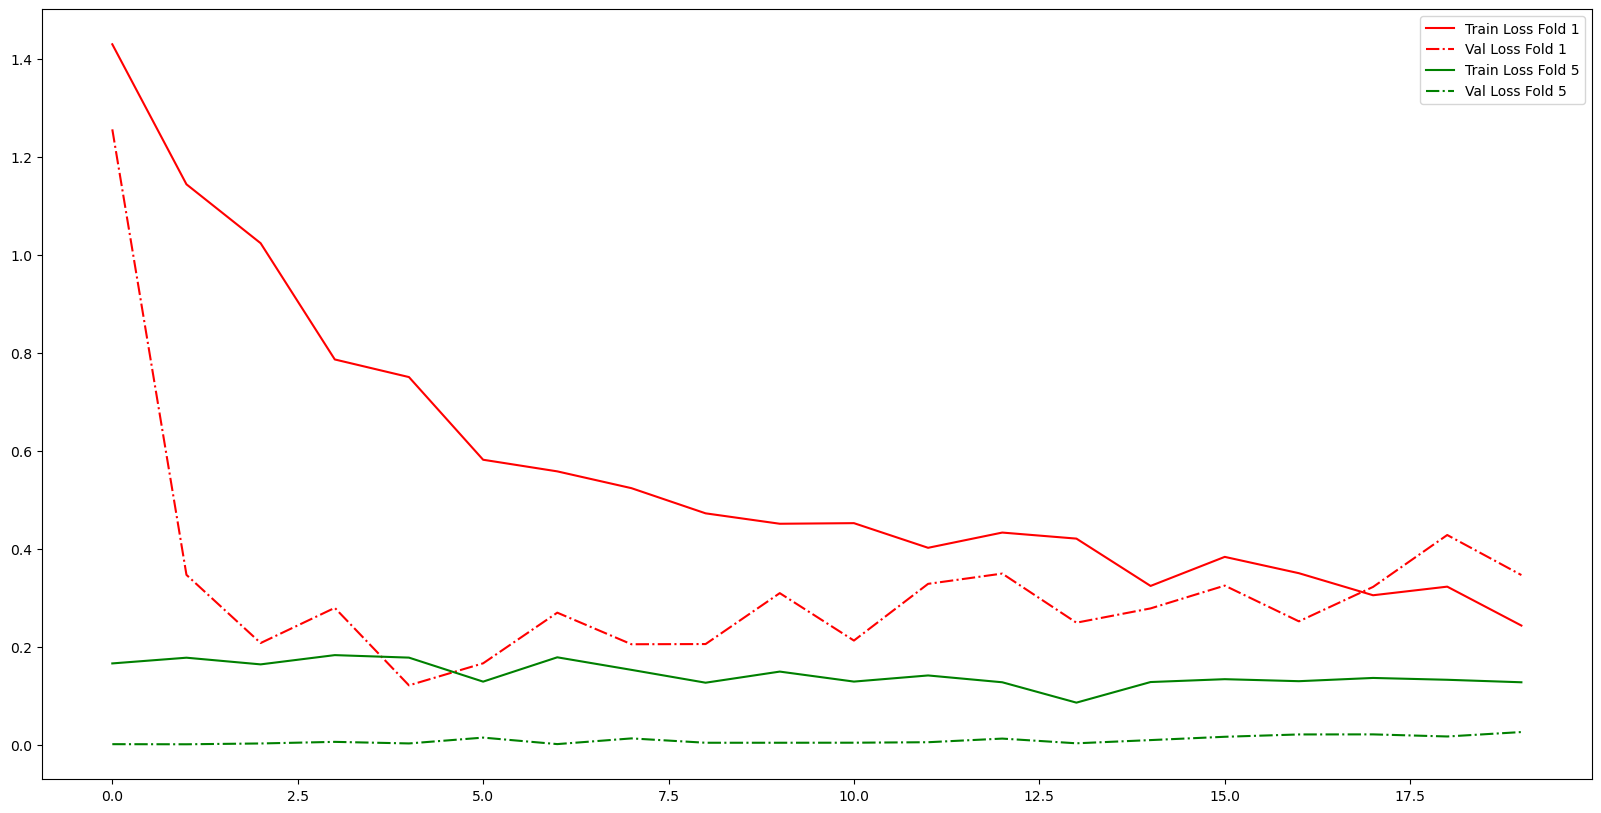

In [30]:
plt.figure(figsize=(20, 10))
plt.plot(loss_per_fold[0], label='Train Loss Fold 1', color='red')
plt.plot(val_loss_per_fold[0], label='Val Loss Fold 1', color='red', linestyle = "dashdot")
plt.plot(loss_per_fold[4], label='Train Loss Fold 5', color='green')
plt.plot(val_loss_per_fold[4], label='Val Loss Fold 5', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

In [29]:
test_images_data, test_images_label = preprocess_images(test_path)
test_images_label = encoding_targets(test_images_label)
predict = np.argmax(model.predict(np.array(test_images_data)),axis=1)
print('Test Data accuracy: ',accuracy_score(test_images_label, predict)*100)
print("\nConfusion Matrix : ")
cnf_matrix = confusion_matrix(test_images_label, predict)
print(cnf_matrix)
print("\nClassification Report :")
print(classification_report(test_images_label, predict, target_names=class_names))

15/15 [==============================] - 1s 26ms/step
Test Data accuracy:  90.77253218884121

Confusion Matrix : 
[[ 90   0   4   0   3]
 [  0  61   7   0   9]
 [  0   1 109   1   3]
 [  1   2   0  65   1]
 [  0  10   1   0  98]]

Classification Report :
              precision    recall  f1-score   support

     downdog       0.99      0.93      0.96        97
     goddess       0.82      0.79      0.81        77
       plank       0.90      0.96      0.93       114
        tree       0.98      0.94      0.96        69
    warrior2       0.86      0.90      0.88       109

    accuracy                           0.91       466
   macro avg       0.91      0.90      0.91       466
weighted avg       0.91      0.91      0.91       466



#### From heatmap visualization we can see a lot of goddess images were predicted as warrior2

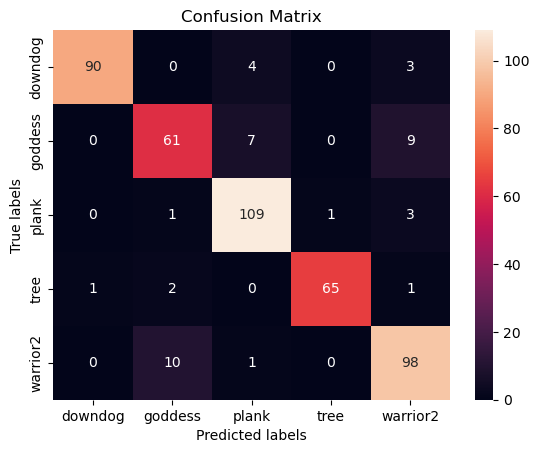

In [31]:
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['downdog', 'goddess','plank','tree','warrior2']); ax.yaxis.set_ticklabels(['downdog', 'goddess','plank','tree','warrior2']);